<a href="https://colab.research.google.com/github/Yyzhang2000/mini-MoE/blob/main/gan/01_mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

from tqdm.autonotebook import trange, tqdm

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 128
data_path = "./data"

cuda


In [47]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
    ])

train_dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=data_path, train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim , output_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc4 = nn.Linear(hidden_dim * 4, output_dim)

        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, 1)

        self.act = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))
        x = self.dropout(self.act(self.fc3(x)))

        return F.sigmoid(self.fc4(x))


In [49]:
mnist_dim = 28 * 28
z_dim = 100

In [50]:
generator = Generator(
    input_dim=100,
    hidden_dim=256,
    output_dim=mnist_dim
).to(device)

discriminator = Discriminator(input_dim=mnist_dim, hidden_dim=1024).to(device)

In [51]:
criterion = nn.BCELoss()

lr = 1e-4
g_optimizer = optim.Adam(generator.parameters(), lr = lr )
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr )

In [52]:
def train_discrimator(data):
    B = data.shape[0]
    x_real, y_real = data.view(-1, mnist_dim), torch.ones(B, 1)
    x_real = x_real.to(device)
    y_real = y_real.to(device)

    model_out = discriminator(x_real)
    model_real_loss = criterion(model_out, y_real)
    model_real_score = model_out

    # Training Discrimnator on fake image
    z = torch.randn(B, z_dim).to(device)
    x_fake, y_fake = generator(z), torch.zeros(B, 1).to(device)

    model_out = discriminator(x_fake)
    model_fake_loss = criterion(model_out, y_fake)
    model_fake_score = model_out

    model_loss = model_real_loss + model_fake_loss
    d_optimizer.zero_grad()
    model_loss.backward()
    d_optimizer.step()

    return model_loss.item()


In [53]:
def train_generator(data):
    B = data.shape[0]
    z = torch.randn(B, z_dim).to(device)
    y = torch.ones(B, 1).to(device)

    model_output = generator(z)
    distrimator_output = discriminator(model_output)
    model_loss = criterion(distrimator_output, y)

    g_optimizer.zero_grad()
    model_loss.backward()
    g_optimizer.step()

    return model_loss.item()

In [54]:
n_epochs = 100

def train():
    for epoch in trange(1, n_epochs + 1):
        d_losses, g_losses = [], []

        for x, _ in tqdm(train_loader):
            d_loss = train_discrimator(x)
            g_loss = train_generator(x)

            d_losses.append(d_loss)
            g_losses.append(g_loss)

    return d_losses, g_losses

In [55]:
d_losses, g_losses = train()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

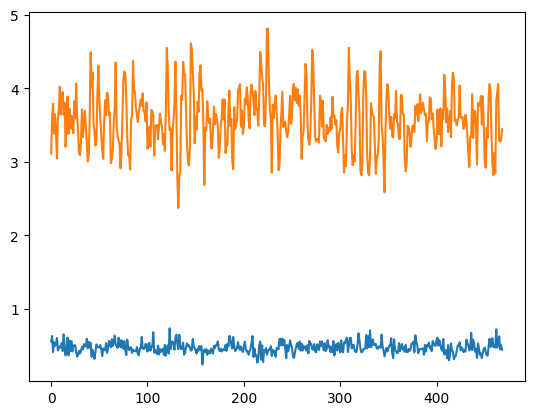

In [56]:
import matplotlib.pyplot as plt
plt.plot(d_losses)
plt.plot(g_losses)

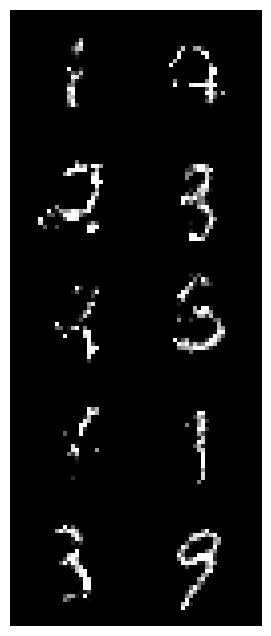

In [60]:
num_imgs = 10
with torch.no_grad():
    test_z = torch.randn(num_imgs, z_dim).to(device)
    generated = generator(test_z)
    generated = generated.reshape(num_imgs,1,  28, 28)

    grid = make_grid(generated, nrow=2)  # Normalize for visualization

    # Convert to NumPy for matplotlib
    grid_np = grid.cpu().permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)

    # Plot using matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_np)
    plt.axis("off")  # Remove axes for better visualization
    plt.show();

    # save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' + '.png')